## Importing all required libraries

In this notebook I will be using Support Vector Machines(SVM), Logistic Regression and Decision Tree for comparitive study. Neural Networks and XGBoost Classifier are our proposed approaches and we would try to get more accuracy then the already tried approaches.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from fastai.tabular import *
import xgboost as xgb
import graphviz
import os

/Users/sahiljajodia/Projects/ML-Python/venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv("merged_5s.csv")

/Users/sahiljajodia/Projects/ML-Python/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,...,Bwd IAT Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,10.0.2.15,53913,216.58.208.46,80,6,435,0,4597.7,435.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
1,10.0.2.15,53913,216.58.208.46,80,6,259,0,7722.01,259.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
2,10.0.2.15,53913,216.58.208.46,80,6,891,0,2244.67,891.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
3,10.0.2.15,53913,216.58.208.46,80,6,1074,0,1862.2,1074.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
4,10.0.2.15,53913,216.58.208.46,80,6,315,0,6349.21,315.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR


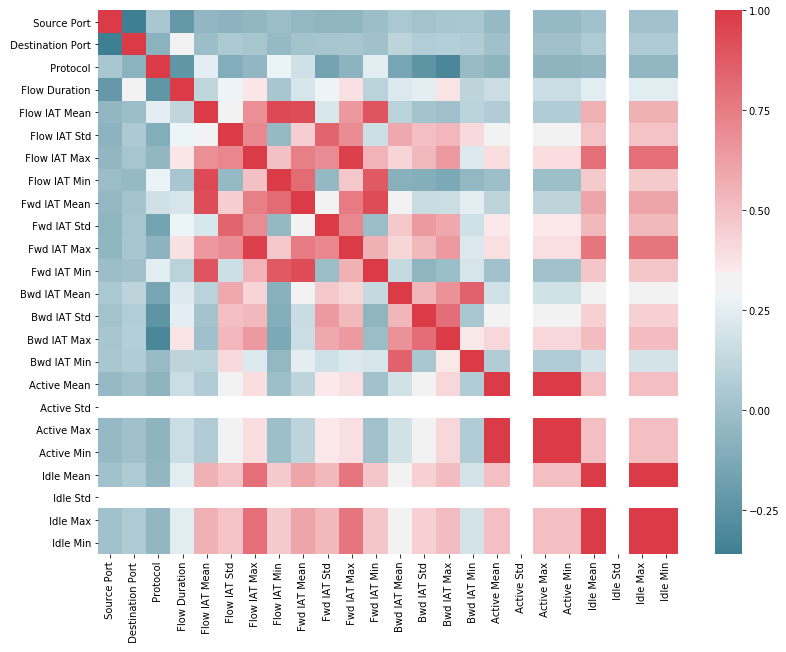

In [4]:
corr = df.corr()
# mask = np.zeros_like(corr, dtype=np.bool)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.rcParams['figure.figsize'] = [13, 10]
sns.heatmap(corr, cmap=cmap)

# Data preprcessing

Here we are dropping the columns **Source IP**, **Destination IP**, **Source Port**, **Destination Port**, **Flow Bytes/s**, **Flow Packets/s** because they do not contribute much to the final result. Also, it can be seen from the above correlation matrix that Source Port and Destination Port are not contributing much due to low correlation. Also, the class is not dependent on the Source IP and Destination IP of the request. Also, our aim is to predict whether request came from tor or non-tor network which clearly doesn't depend on the size of the packet or the number of packets sent.

In [5]:
df = df.drop(columns=["Source IP", " Destination IP", " Source Port", " Destination Port", " Flow Bytes/s", " Flow Packets/s"])

### Seperating the features and classes from th dataframe.

In [6]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

### Splitting the dataset into training and testing datasets. Testing dataset is 25% of the whole dataset.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Compartive study methods

## 1) Logistic Regression

In [8]:
logisticClassifier = LogisticRegression(random_state=0)
logisticClassifier.fit(np.nan_to_num(X_train), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [9]:
logisticClassifier.score(np.nan_to_num(X_test), y_test)

0.8621787258302057

## 2) Decision Tree

In [10]:
treeClassifier = DecisionTreeClassifier(max_depth=5, random_state=0)
treeClassifier.fit(np.nan_to_num(X_train), y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [11]:
treeClassifier.score(np.nan_to_num(X_test), y_test)

0.9374317069694522

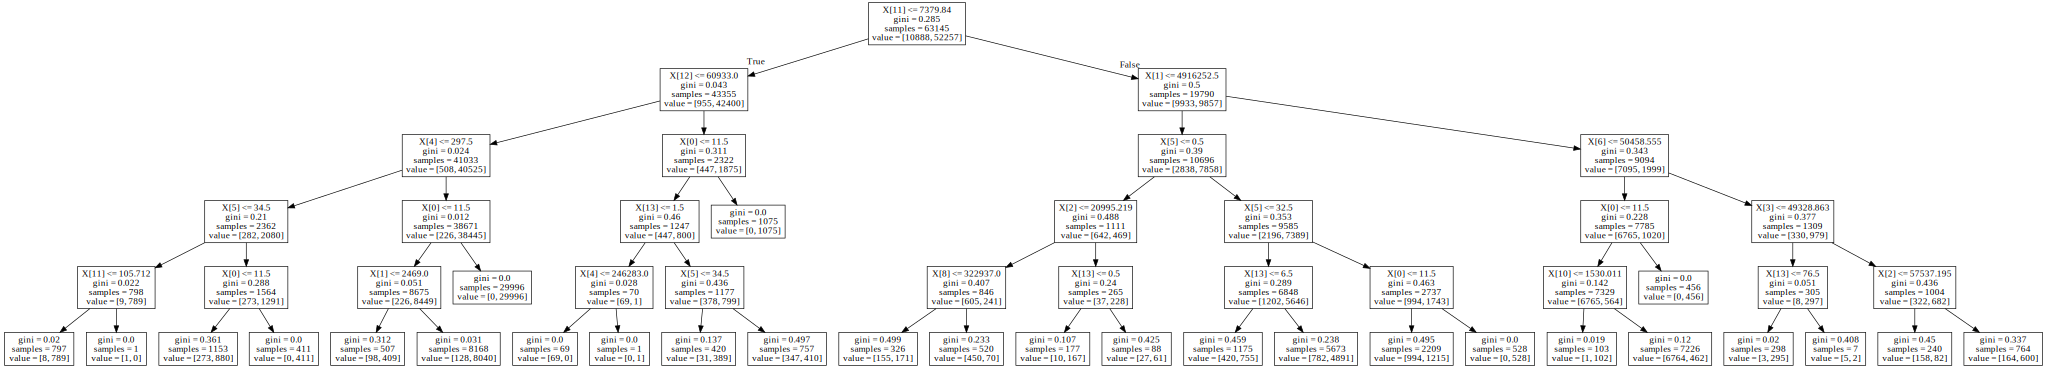

In [12]:
dot_data = tree.export_graphviz(treeClassifier, out_file=None)
graph = graphviz.Source(dot_data)
graph

## 3) Support vector Machines (SVM)

In [17]:
svm_clf = svm.LinearSVC(random_state=0)
svm_clf.fit(np.nan_to_num(X_train), y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

In [18]:
svm_clf.score(np.nan_to_num(X_test), y_test)

0.6448762411515987

# Proposed solutions

## 1) Neural Networks

In [20]:
path = os.getcwd()
procs = [FillMissing, Categorify, Normalize]
valid_idx = range(len(df)-10000, len(df))
dep_var = 'label'
cat_names = [' Protocol']
data = TabularDataBunch.from_df(path, df=df, dep_var=dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)
(cat_x,cont_x),y = next(iter(data.train_dl))

Here we are using a neural network of two hidden layers having 200 and 100 neurons each. These hidden layers are densely connected to each other and the output layer. We are doing 10 epochs with learning rate alpha=0.01. Also, below we can see the architecture of the neural network that we are going to use for this classification.

In [24]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU(inplace)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [21]:
learn = tabular_learner(data, layers=[200,100] , metrics=accuracy)
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.151349,0.372399,0.879400,00:09
1,0.145328,0.575733,0.849900,00:09
2,0.126597,0.478707,0.833400,00:09
3,0.135114,0.508937,0.860800,00:08
4,0.126989,0.483280,0.855600,00:08
5,0.115301,0.418517,0.860900,00:08
6,0.106370,0.469874,0.871100,00:08
7,0.107780,0.431229,0.867300,00:08
8,0.100187,0.430248,0.863300,00:09
9,0.103760,0.432519,0.862700,00:08


In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Here we are plotting a graph of the loss for different learning rates. As we can see that neural nets are just not consistent enough to get high accuracy for any value of alpha. 

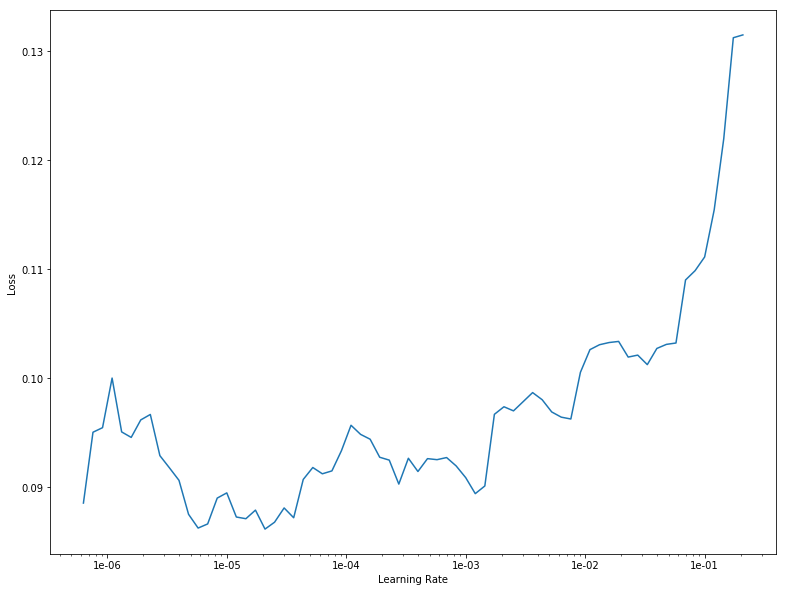

In [23]:
learn.recorder.plot()

As we can see from the above output that nueral networks already performs worser than Decision tree classifier. Seeing this result we can thing of using another tree based algorithm which is **XGBoost Classifier**. Also, we can conclude that neural networks are not a solution to every problem and sometimes pure machine learning algorithms work better for some problems.

## 2) XGBoost

In [28]:
xgdmat = xgb.XGBClassifier(random_state=0)
final_gb = xgdmat.fit(np.nan_to_num(X_train), y_train)
pred1 = final_gb.predict(X_test)

/Users/sahiljajodia/Projects/ML-Python/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [29]:
print("Accuracy for model: %.2f" % (accuracy_score(y_test, pred1) * 100))

Accuracy for model: 95.71


Here we can see that XGBoost has given us the highest accuracy among all the models that we have tried till now.

The graph below shows us that which features from the dataset has been given the highest importance in the descending order of their importance.

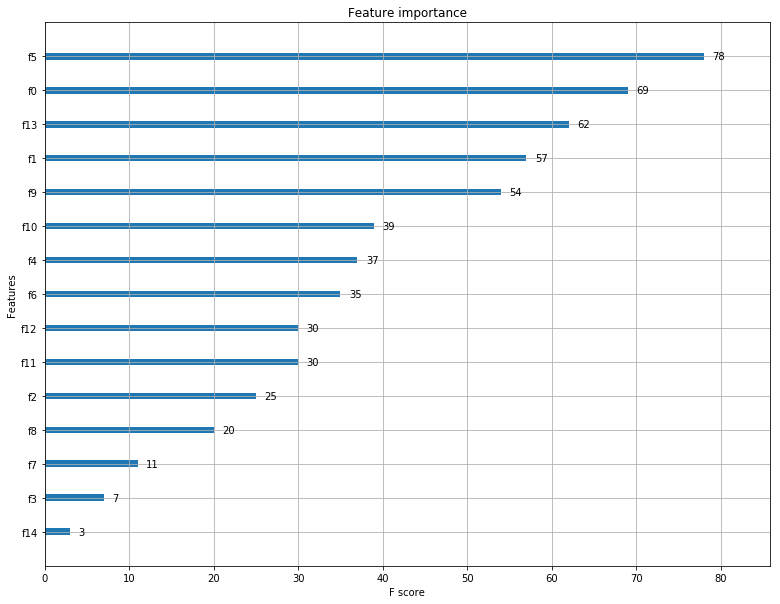

In [30]:
xgb.plot_importance(final_gb)